## import libraries

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random
import tensorflow as tf
import json
import seaborn as sns
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
print(os.listdir("input/data/")) # ../input

[&#39;.DS_Store&#39;, &#39;sampleSubmission.csv&#39;, &#39;test1&#39;, &#39;train&#39;]


## Define constants

In [12]:
FAST_RUN = False
BATCH_SIZE = 32
EPOCHS = 50

IMAGE_WIDTH = 128
IMAGE_HEIGHT = 128
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 3

# Data exploration

In [13]:
# PUT DATA EXPLORATION STUFF HERE

## Preparing training data

In [14]:
filenames = os.listdir("input/data/train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [15]:
print('filenames:', filenames[:10])
print(categories[:10])

filenames: [&#39;dog.8011.jpg&#39;, &#39;cat.5077.jpg&#39;, &#39;dog.7322.jpg&#39;, &#39;cat.2718.jpg&#39;, &#39;cat.10151.jpg&#39;, &#39;cat.3406.jpg&#39;, &#39;dog.1753.jpg&#39;, &#39;cat.4369.jpg&#39;, &#39;cat.7660.jpg&#39;, &#39;dog.5535.jpg&#39;]
[1, 0, 1, 0, 0, 0, 1, 0, 0, 1]


In [16]:
# Show it with Pandas
df.head()

,filename,category
0,dog.8011.jpg,1
1,cat.5077.jpg,0
2,dog.7322.jpg,1
3,cat.2718.jpg,0
4,cat.10151.jpg,0


In [17]:
df['category'].value_counts()

1    12500
0    12500
Name: category, dtype: int64

&lt;AxesSubplot:ylabel=&#39;category&#39;&gt;

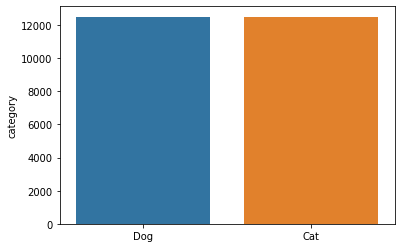

In [18]:
#df['category'].value_counts().plot.bar()
sns.barplot(x=['Dog', 'Cat'], y=df['category'].value_counts())

## Sample image

&lt;matplotlib.image.AxesImage at 0x14a9aea60&gt;

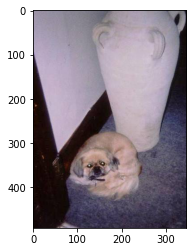

In [19]:
sample = random.choice(filenames)
image = load_img('input/data/train/'+sample)
plt.imshow(image)

## Build model

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

# Input Layer: It represent input image data. It will reshape image into single diminsion array. Example your image is 64x64 = 4096, it will convert to (4096,1) array.
# Conv Layer: This layer will extract features from image.
# Pooling Layer: This layerreduce the spatial volume of input image after convolution.
# Fully Connected Layer: It connect the network from a layer to another layer
# Output Layer: It is the predicted values layer.


In [21]:
model = Sequential()


In [22]:
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: &quot;sequential&quot;
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 12

## Callbacks

In [23]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

### Early Stop
To prevent over fitting we will stop the learning after 10 epochs and val_loss value not decreased

In [24]:
earlystop = EarlyStopping(patience=10)


Learning Rate Reduction

We will reduce the learning rate when then accuracy not increase for 2 steps


In [25]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [26]:
callbacks = [earlystop, learning_rate_reduction]

# Preparing data
Because we will use image genaretor with class_mode="categorical". 
We need to convert column category into string. 
Then imagenerator will convert it one-hot encoding which is good for our classification.

So we will convert 1 to dog and 0 to cat

In [27]:
df['category'] = df['category'].replace({0: 'cat', 1: 'dog'})

In [28]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [29]:
train_df.shape

(20000, 2)

In [30]:
validate_df.shape

(5000, 2)

&lt;AxesSubplot:&gt;

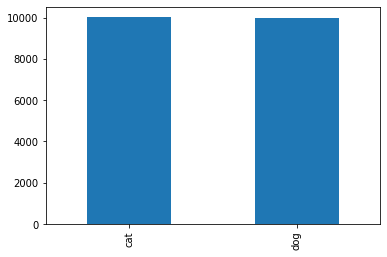

In [31]:
train_df['category'].value_counts().plot.bar()

&lt;AxesSubplot:&gt;

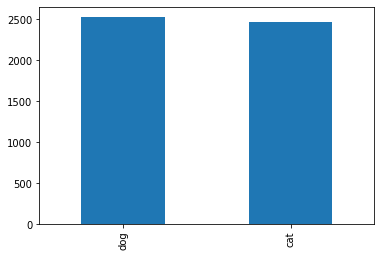

In [32]:
validate_df['category'].value_counts().plot.bar()

In [33]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

# Training Generator
Augmentation of Training data

In [34]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)
train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "input/data/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE
)

Found 20000 validated image filenames belonging to 2 classes.


## visualize augmented training data

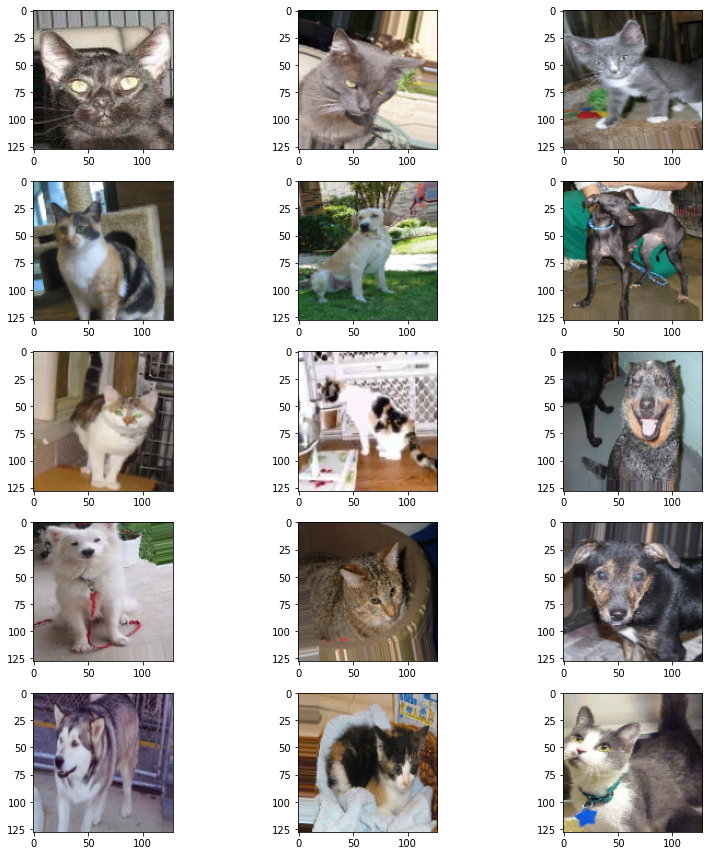

In [35]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in train_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

# Validation Generator
Augmentation of Test data is not existing. Because we want to test our model on life-like images.

In [36]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "input/data/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE
)

Found 5000 validated image filenames belonging to 2 classes.


# Visualise the Generator

Found 1 validated image filenames belonging to 1 classes.


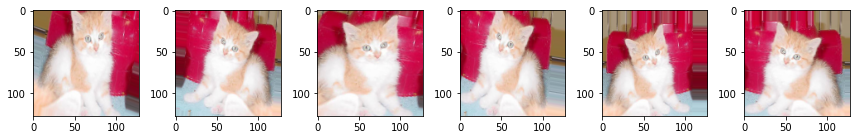

In [37]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "input/data/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

plt.figure(figsize=(12, 12))
for i in range(0, 6):
    plt.subplot(1, 6, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

# Fit model

In [39]:
# FAST_RUN = True
EPOCHS = 3 if FAST_RUN else 20
history = model.fit_generator(
    train_generator, 
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=total_validate//BATCH_SIZE,
    steps_per_epoch=total_train//BATCH_SIZE,
    callbacks=callbacks
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
  9/625 [..............................] - ETA: 4:01 - loss: 2.3950 - accuracy: 0.5625

KeyboardInterrupt: 

# Save model & history

In [41]:
# Saving only the weights of the model
# model.save_weights("model.h5")

# Saving complete model
model.save('saved-models/catvsdog-model')

# Save history to json
# Get the dictionary containing each metric and the loss for each epoch
history_dict = history.history
# Save it under the form of a json file
json.dump(str(history_dict), open('saved-models/history/dogvscat-model-history.json', 'w'))

INFO:tensorflow:Assets written to: saved-models/catvsdog-model/assets


NameError: name &#39;history_dict&#39; is not defined

# Load model

In [42]:
# Load model from disk
model = tf.keras.models.load_model('saved-models/catvsdog-model')

# Load history from JSON file
history_dict = json.load(open('saved-models/history/dogvscat-model-history.json', 'r'))

In [43]:
model.save('potato.h5')

# Visualize Training

In [59]:
loss, accuracy = model.evaluate_generator(validation_generator, total_validate//BATCH_SIZE, workers=12)
print("Test: accuracy = %f  ;  loss = %f " % (accuracy, loss))

Test: accuracy = 0.932091  ;  loss = 0.179070 


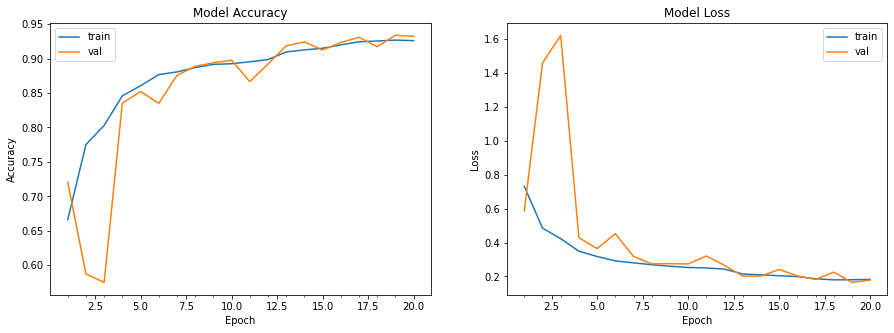

In [188]:
# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
# ax1.plot(history.history['loss'], color='b', label="Training loss")
# ax1.plot(history.history['val_loss'], color='r', label="validation loss")
# ax1.set_xticks(np.arange(1, EPOCHS, 1))
# ax1.set_yticks(np.arange(0, 1, 0.1))

# ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
# ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
# ax2.set_xticks(np.arange(1, EPOCHS, 1))

# legend = plt.legend(loc='best', shadow=True)
# plt.tight_layout()
# plt.show()


def plot_model_history(model_history, acc='accuracy', val_acc='val_accuracy'): # DEZE PLOTTING IS NICER
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    axs[0].plot(range(1,len(model_history[acc])+1),model_history[acc])
    axs[0].plot(range(1,len(model_history[val_acc])+1),model_history[val_acc])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history[acc])+1),len(model_history[acc])/10)
    axs[0].legend(['train', 'val'], loc='best')

    axs[1].plot(range(1,len(model_history['loss'])+1),model_history['loss'])
    axs[1].plot(range(1,len(model_history['val_loss'])+1),model_history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history['loss'])+1),len(model_history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()
    
plot_model_history(history_dict)

In [266]:
Y_val = validate_df['category'].replace({'dog': 1, 'cat': 0})
y_pred =  model.predict_generator(validation_generator)

In [270]:
#threshold = 0.5
y_final = np.argmax(predict, axis=-1) #np.where(y_pred > threshold, 1,0)

In [271]:
y_final.size

12500

In [272]:
Y_val.size

5000

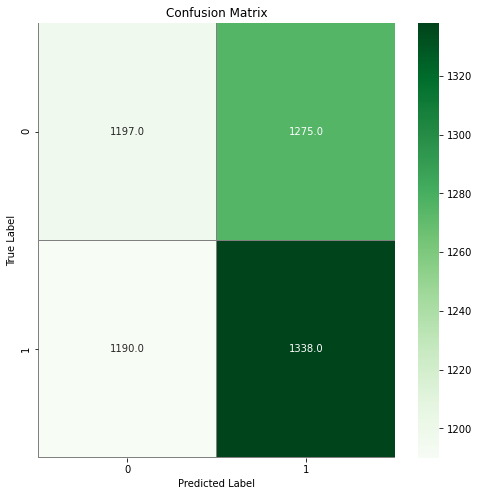

In [273]:
from sklearn.metrics import confusion_matrix
# Predict the values from the validation dataset

# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_val, y_final[0:5000]) 
# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [275]:
from sklearn.metrics import classification_report

# Generate a classification report
report = classification_report(Y_val, y_final[0:5000], target_names=['0','1'])

print(report)

              precision    recall  f1-score   support

           0       0.50      0.48      0.49      2472
           1       0.51      0.53      0.52      2528

    accuracy                           0.51      5000
   macro avg       0.51      0.51      0.51      5000
weighted avg       0.51      0.51      0.51      5000



# Prepare Testing Data

In [277]:
test_filenames = os.listdir("input/data/test1")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

## Creating Generator for Test data

In [278]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "input/data/test1/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 12500 validated image filenames.


## Predict

In [279]:
predict = model.predict(test_generator, steps=np.ceil(nb_samples / BATCH_SIZE))

For categoral classication the prediction will come with probability of each category. So we will pick the category that have the highest probability with numpy average max


In [280]:
test_df['category'] = np.argmax(predict, axis = -1)

We will convert the predict category back into our generator classes by using train_generator.class_indices. It is the classes that image generator map while converting data into computer vision

In [281]:
label_map = dict((v, k) for k, v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

In [282]:
train_generator.class_indices.items()

dict_items([('cat', 0), ('dog', 1)])

From our prepare data part. We map data with {1: 'dog', 0: 'cat'}. Now we will map the result back to dog is 1 and cat is 0

In [283]:
test_df['category'] = test_df['category'].replace({'dog': 1, 'cat': 0})

# Virtualise results

<AxesSubplot:>

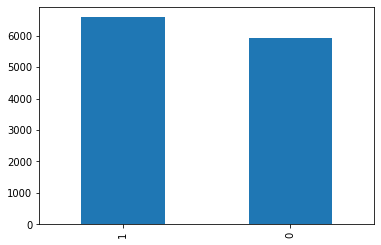

In [284]:
test_df['category'].value_counts().plot.bar()

## See predicted result with images

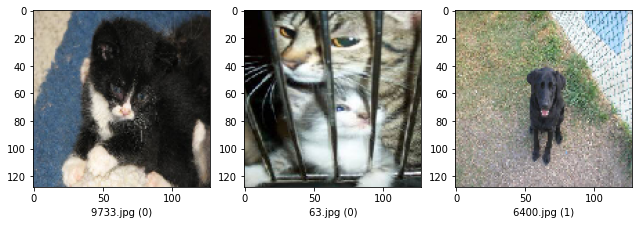

In [285]:
sample_test = test_df.head(3)
sample_test.head()
plt.figure(figsize=(9, 18))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("input/data/test1/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + ' (' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

# Netron

In [2]:
# Load the TensorBoard notebook extension.
%load_ext tensorboard

In [3]:
from datetime import datetime
from packaging import version

import tensorflow as tf
from tensorflow import keras

print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >= 2, \
    "This notebook requires TensorFlow 2.0 or above."


TensorFlow version:  2.3.0


In [4]:
import tensorboard
tensorboard.__version__

&#39;2.3.0&#39;

In [5]:
# Define the Keras TensorBoard callback.
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

In [6]:
import

In [44]:
netron.start('potato.h5')


Stopping http://localhost:8080
Serving &#39;potato.h5&#39; at http://localhost:8080
